# Practice: Dealing with texts using CNN
_Reference: Based on YSDA [materials](https://github.com/yandexdataschool/nlp_course/blob/master/week02_classification/seminar.ipynb). Special thanks to [Oleg Vasilev](https://github.com/Omrigan/) for the core assignment idea._

Today we're gonna apply the newly learned tools for the task of predicting job salary.

<img src="https://storage.googleapis.com/kaggle-competitions/kaggle/3342/media/salary%20prediction%20engine%20v2.png" width=400px>

## About the challenge
For starters, let's download and unpack the data.

You can also get it from [Yandex.Disk](https://yadi.sk/d/vVEOWPFY3NruT7) or [the competition page](https://www.kaggle.com/c/job-salary-prediction/data) (pick `Train_rev1.*`).

In [1]:
!curl -L "https://www.dropbox.com/s/5msc5ix7ndyba10/Train_rev1.csv.tar.gz?dl=1" -o Train_rev1.csv.tar.gz
!tar xzf Train_rev1.csv.tar.gz

curl: /opt/conda/lib/libcurl.so.4: no version information available (required by curl)
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    17    0    17    0     0     24      0 --:--:-- --:--:-- --:--:--    24
100   342  100   342    0     0    270      0  0:00:01  0:00:01 --:--:--     0
100  119M  100  119M    0     0  12.6M      0  0:00:09  0:00:09 --:--:-- 19.6M


In [2]:
import time
import matplotlib.pyplot as plt
plt.style.use("dark_background")
import numpy as np

import pandas as pd
from sklearn.metrics import r2_score

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler

In [3]:
data = pd.read_csv("/kaggle/working/Train_rev1.csv", index_col=None)
data.shape

(244768, 12)

In [4]:
data.head(3)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
0,12612628,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk
1,12612830,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,"Glasgow, Scotland, Scotland",Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 35000/annum 25-35K,30000,cv-library.co.uk
2,12612844,Modelling and simulation analyst,Mathematical Modeller / Simulation Analyst / O...,"Hampshire, South East, South East",Hampshire,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 40000/annum 20-40K,30000,cv-library.co.uk


In [5]:
data.ContractType.value_counts()

full_time    57538
part_time     7904
Name: ContractType, dtype: int64

In [6]:
data.ContractTime.value_counts()

permanent    151521
contract      29342
Name: ContractTime, dtype: int64

In [7]:
data.Company.value_counts()

UKStaffsearch          4997
CVbrowser              2977
London4Jobs            2345
Hays                   1784
JAM Recruitment Ltd    1122
                       ... 
Your Golf Travel          1
YMCAfit                   1
The Park Club             1
Celtic Manor Resort       1
DMC Healthcare            1
Name: Company, Length: 20812, dtype: int64

One problem with salary prediction is that it's oddly distributed: there are many people who are paid standard salaries and a few that get tons o money. The distribution is fat-tailed on the right side, which is inconvenient for MSE minimization.

There are several techniques to combat this: using a different loss function, predicting log-target instead of raw target or even replacing targets with their percentiles among all salaries in the training set. We gonna use logarithm for now.

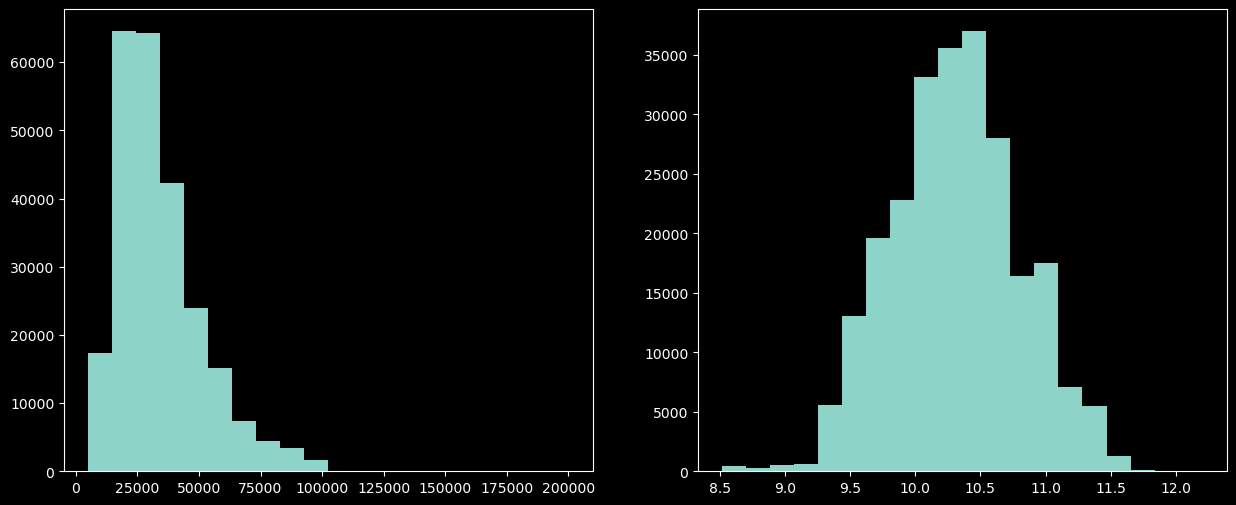

In [8]:
data["Log1pSalary"] = np.log1p(data["SalaryNormalized"]).astype("float32")

plt.figure(figsize=[15, 6])
plt.subplot(1, 2, 1)
plt.hist(data["SalaryNormalized"], bins=20)

plt.subplot(1, 2, 2)
plt.hist(data["Log1pSalary"], bins=20)

plt.show()

Our task is to predict one number, __Log1pSalary__.

To do so, our model can access a number of features:
* Free text: __`Title`__ and  __`FullDescription`__
* Categorical: __`Category`__, __`Company`__, __`LocationNormalized`__, __`ContractType`__, and __`ContractTime`__.

In [9]:
text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
target_column = "Log1pSalary"

data[categorical_columns] = data[categorical_columns].fillna("NaN")
data[text_columns] = data[text_columns].fillna("NaN")

data.sample(3)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
189044,71706644,Senior Control System Engineer PLC/SCADA,Senior Control System Engineer PLC/SCADA requ...,South Yorkshire South Yorkshire England,South Yorkshire,NaN,NaN,Redline Group,Engineering Jobs,40000 -50000 per annum,45000,gojobsearch.co.uk,10.714440
130843,70172040,Market Research Interviewer,Market Research Interviewer No experience is r...,"Lowestoft, Suffolk",Lowestoft,NaN,permanent,Search Consultancy,"PR, Advertising & Marketing Jobs",150 - 300/week Expenses and provisions,10800,cv-library.co.uk,9.287394
33556,68181642,Junior Quantity Surveyor,This Principle Engineering Contracting company...,Surrey,Surrey,NaN,permanent,Advance Training Recruitment Services Ltd,Trade & Construction Jobs,"25,000 - 32,000 pa",28500,jobsite.co.uk,10.257694


## Preprocessing text data

Just like last week, applying NLP to a problem begins from tokenization: splitting raw text into sequences of tokens (words, punctuation, etc).

__Your task__ is to lowercase and tokenize all texts under `Title` and `FullDescription` columns. Store the tokenized data as a __space-separated__ string of tokens for performance reasons.

It's okay to use nltk tokenizers. Assertions were designed for WordPunctTokenizer, slight deviations are okay.

In [10]:
print("Raw text:")
print(data["FullDescription"][2::100000])

Raw text:
2         Mathematical Modeller / Simulation Analyst / O...
100002    A successful and high achieving specialist sch...
200002    Web Designer  HTML, CSS, JavaScript, Photoshop...
Name: FullDescription, dtype: object


In [11]:
from nltk.tokenize import WordPunctTokenizer

tokenizer = WordPunctTokenizer()

# YOUR CODE HERE
# Lowercase and tokenize titles and descriptions (text_columns).
# Store items as space-separated strings of tokens.
def normalize(text: str):  # noqa: E302
    tokens = tokenizer.tokenize(str(text).lower())
    return " ".join(tokens)


data[text_columns] = data[text_columns].applymap(normalize)

In [16]:
print("Tokenized:")
print(data["FullDescription"][2::100_000])
assert data["FullDescription"][2][:50] == "mathematical modeller / simulation analyst / opera"
assert data["Title"][54321] == "international digital account manager ( german )"

Tokenized:
2         mathematical modeller / simulation analyst / o...
100002    a successful and high achieving specialist sch...
200002    web designer html , css , javascript , photosh...
Name: FullDescription, dtype: object


Not all words are equally useful. Some of them are typos or rare words that are only present a few times. 

Let's count how many times is each word present in the data so that we can build a "white list" of known words.

In [17]:
from collections import Counter

# YOUR CODE HERE
# Count how many times does each token occur in both "Title" and "FullDescription".
# Build a dictionary { token -> count }.
# Hint: you may or may not want to use collections.Counter

token_counts = Counter()

for row in data[text_columns].values.flatten():
    token_counts.update(row.split())

In [18]:
print("Total unique tokens :", len(token_counts))
print("\n".join(map(str, token_counts.most_common(n=5))))
print("...")
print("\n".join(map(str, token_counts.most_common()[-3:])))

assert token_counts.most_common(1)[0][1] in range(2600000, 2700000)
assert len(token_counts) in range(200000, 210000)
print("Correct!")

Total unique tokens : 202704
('and', 2657388)
('.', 2523216)
(',', 2318606)
('the', 2080994)
('to', 2019884)
...
('stephanietraveltraderecruitmnt', 1)
('ruabon', 1)
('lowehays', 1)
Correct!


Let's see how many words are there for each count.

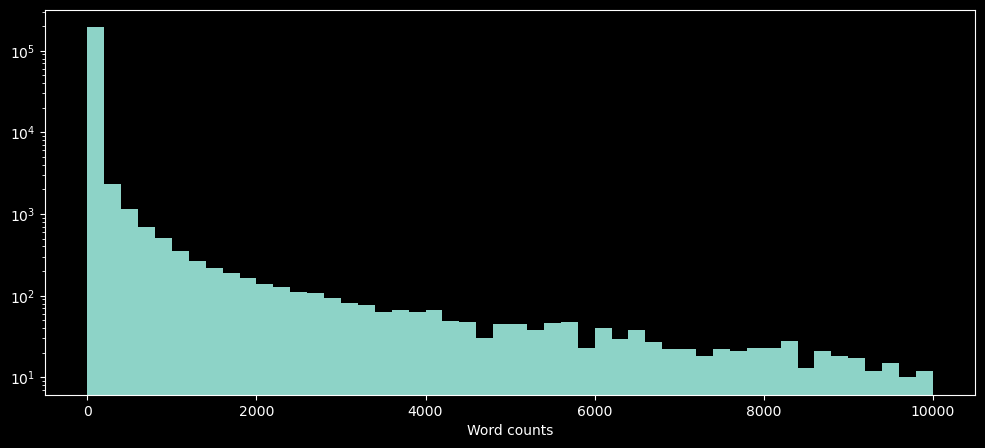

In [19]:
plt.figure(figsize=(12, 5))
plt.hist(list(token_counts.values()), range=[0, 10 ** 4], bins=50, log=True)
plt.xlabel("Word counts")
plt.show()

Now we will filter tokens a list of all tokens that occur at least 10 times.

In [20]:
list(token_counts.items())[:3]

[('engineering', 68563), ('systems', 77071), ('analyst', 34427)]

In [21]:
min_count = 10

# YOUR CODE HERE
# We shall only consider tokens that had at least min_count occurences.
# Create a list of such tokens.
tokens = [token for token, count in token_counts.items() if count > min_count]
print("Total unique tokens :", len(token_counts))
print("Considered unique tokens :", len(tokens))

Total unique tokens : 202704
Considered unique tokens : 32454


In [22]:
# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + sorted(tokens)
print("Vocabulary size:", len(tokens))

assert type(tokens) == list
assert len(tokens) in range(32000, 35000)
assert "me" in tokens
assert UNK in tokens
print("Correct!")

Vocabulary size: 32456
Correct!


Build an inverse token index: a dictionary from token to it's index in `tokens`.

In [23]:
# YOUR CODE HERE
token_to_idx = {token: idx for idx, token in enumerate(tokens)}

In [24]:
assert isinstance(token_to_idx, dict)
assert len(token_to_idx) == len(tokens)

for tok in tokens:
    assert tokens[token_to_idx[tok]] == tok

print("Correct!")

Correct!


And finally, let's use the vocabulary you've built to map text lines into neural network-digestible matrices.

In [25]:
UNK_IDX = token_to_idx[UNK]
PAD_IDX = token_to_idx[PAD]


def as_matrix(sequences, max_len=None):
    """Convert a list of tokens into a matrix with padding"""
    if isinstance(sequences[0], str):
        sequences = [seq.split(" ") for seq in sequences]

    sequences_max_len = max(len(seq) for seq in sequences)
    if max_len is None:
        max_len = sequences_max_len
    else:
        max_len = min(sequences_max_len, max_len)

    matrix = np.full((len(sequences), max_len), PAD_IDX)
    for i, seq in enumerate(sequences):
        for j, token in enumerate(seq):
            if j >= max_len:
                break

            matrix[i, j] = token_to_idx.get(token, UNK_IDX)

    return matrix

In [26]:
print("Lines:")
print("\n".join(data["Title"][::100000].values), end="\n\n")
print("Matrix:")
print(as_matrix(data["Title"][::100000]))

Lines:
engineering systems analyst
hr assistant
senior ec & i engineer

Matrix:
[[10273 28655  2055     1     1]
 [14296  2700     1     1     1]
 [26272  9698    14 14484 10270]]


Now let's  encode the categirical data we have.

As usual, we shall use one-hot encoding for simplicity. Kudos if you implement more advanced encodings: tf-idf, pseudo-time-series, etc.

In [27]:
# how works dictvectorizer
from sklearn.feature_extraction import DictVectorizer
categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
dd = pd.Series([{"key_11": 100, "key_21": 200, "key31": 300}, {"key_11": 150, "key_21": 250, "key31": 350}])
categorical_vectorizer.fit_transform(dd)

array([[300., 100., 200.],
       [350., 150., 250.]], dtype=float32)

In [28]:
# how works dictvectorizer
from sklearn.feature_extraction import DictVectorizer
categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
dd = pd.Series([{"key_11": "a", "key_21": "b"},
                {"key_11": 100, "key_21": 200},
                {"key_11": "a", "key_21": "300"}])
categorical_vectorizer.fit_transform(dd)

array([[  0.,   1.,   0.,   0.,   1.],
       [100.,   0., 200.,   0.,   0.],
       [  0.,   1.,   0.,   1.,   0.]], dtype=float32)

In [29]:
categorical_columns

['Category', 'Company', 'LocationNormalized', 'ContractType', 'ContractTime']

In [30]:
from sklearn.feature_extraction import DictVectorizer


# We only consider top-1k most frequent companies to minimize memory usage
company_counts = Counter(data["Company"])
top_companies = set(name for name, count in company_counts.most_common(1000))
data["Company"] = data["Company"].apply(
    lambda company: company if company in top_companies else "Other"
)

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1));

## The deep learning part

Once we've learned to tokenize the data, let's design a machine learning experiment.

As before, we won't focus too much on validation, opting for a simple train-test split.

__To be completely rigorous,__ we've comitted a small crime here: we used the whole data for tokenization and vocabulary building. A more strict way would be to do that part on training set only. You may want to do that and measure the magnitude of changes.

In [31]:
data.head(2)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
0,12612628,engineering systems analyst,engineering systems analyst dorking surrey sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk,10.126671
1,12612830,stress engineer glasgow,stress engineer glasgow salary **** to **** we...,"Glasgow, Scotland, Scotland",Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 35000/annum 25-35K,30000,cv-library.co.uk,10.308986


In [32]:
from sklearn.model_selection import train_test_split


data_train, data_val = train_test_split(data, test_size=0.25, random_state=42)
data_train.index = range(len(data_train))
data_val.index = range(len(data_val))

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  183576
Validation size =  61192


In [33]:
def make_batch(data, max_len=None, word_dropout=0):
    """
    Creates a neural-network-friendly dict from the batch data.
    :param word_dropout: replaces token index with UNK_IDX with this probability
    :returns: a dict with {'title' : int64[batch, title_max_len], 
                           "FullDescription": int64[batch, title_max_len],
                           "Categorical"
    """
    batch = {}
    batch["Title"] = as_matrix(data["Title"].values, max_len)
    batch["FullDescription"] = as_matrix(data["FullDescription"].values, max_len)
    batch["Categorical"] = categorical_vectorizer.transform(
        data[categorical_columns].apply(dict, axis=1)
    )

    if word_dropout != 0:
        batch["FullDescription"] = apply_word_dropout(batch["FullDescription"], 1.0 - word_dropout)

    if target_column in data.columns:
        batch[target_column] = data[target_column].values

    return batch


def apply_word_dropout(matrix, keep_prob, replace_with=UNK_IDX):
    dropout_mask = np.random.choice(2, np.shape(matrix), p=[keep_prob, 1 - keep_prob])
    dropout_mask &= matrix != PAD_IDX
    return np.choose(dropout_mask, [matrix, np.full_like(matrix, replace_with)])

In [34]:
example_batch = make_batch(data_train[:3], max_len=10)
print("Example batch:")
print(example_batch)
print("FullDescription shape:", example_batch["FullDescription"].shape)

Example batch:
{'Title': array([[23144, 17928],
       [26272,  1399],
       [ 4391,     1]]), 'FullDescription': array([[25290,   836, 23144, 17928, 17406,   836, 12802, 25632,   836,
        30566],
       [26272,  1399,  5652,  7578,   150, 17464,    77, 21807, 14243,
        19562],
       [31430, 24708, 30193,  4391, 31888, 30756,  7671,  5109, 11963,
          909]]), 'Categorical': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), 'Log1pSalary': array([10.621352, 10.002473, 10.023978], dtype=float32)}
FullDescription shape: (3, 10)


In [35]:
def iterate_minibatches(data, batch_size=256, shuffle=True, cycle=False, **kwargs):
    """iterates minibatches of data in random order"""
    while True:
        indices = np.arange(len(data))
        if shuffle:
            indices = np.random.permutation(indices)

        for start in range(0, len(indices), batch_size):
            batch = make_batch(data.iloc[indices[start : start + batch_size]], **kwargs)
            target = batch.pop(target_column)
            yield batch, target

        if not cycle:
            break

To generate minibatches we will use simple pyton generator.

In [36]:
data_train.head(3)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
0,69042287,project manager,role : project manager location : glasgow sala...,Glasgow Lanarkshire Scotland,UK,NaN,permanent,Other,IT Jobs,35000 - 47000 per annum,41000,cwjobs.co.uk,10.621352
1,68681537,senior administrator,"senior administrator charing cross , london **...",London South East,South East London,NaN,contract,Hays,Other/General Jobs,11.00 - 12.00 per hour,22080,totaljobs.com,10.002473
2,70174267,bricklayers,we require two bricklayers with valid cscs car...,Boston,Boston,full_time,NaN,Other,Trade & Construction Jobs,11.50 - 12.00 per hour,22560,Jobcentre Plus,10.023978


In [37]:
iterator = iterate_minibatches(data_train, 256)
batch, target = next(iterator)
for key in batch:
    print(f"{key}: {batch[key].shape}")

Title: (256, 17)
FullDescription: (256, 1355)
Categorical: (256, 3768)


## Architecture

Our main model consists of three branches:
* Title encoder
* Description encoder
* Categorical features encoder

We will then feed all 3 branches into one common network that predicts salary.

<img src="https://github.com/yandexdataschool/nlp_course/raw/master/resources/w2_conv_arch.png" width=600px>

This clearly doesn't fit into PyTorch __Sequential__ interface. To build such a network, one will have to use [__PyTorch nn.Module API__](https://pytorch.org/docs/stable/nn.html#torch.nn.Module).

But to start with let's build the simple model using only the part of the data. Let's create the baseline solution using only the description part (so it should definetely fit into the Sequential model).

In [41]:
import torch.nn as nn
import torch

# Initially, our FullDescription has a shape [batch_size, seq_len].
# After an Embedding layer shape will be [batch_size, seq_len, embedding_size].
# However, Conv1d layer expects batches of shape [batch_size, embedding_size, seq_len].
# We will use this layer to fix this misunderstanding.
class Reorder(nn.Module):
    def forward(self, input):
        return input.permute((0, 2, 1))

In [42]:
emb_size = 128
out_channels = 256
simple_model = nn.Sequential(
    # YOUR CODE HERE
    nn.Embedding(len(tokens), emb_size),
    Reorder(),
    nn.Conv1d(emb_size, out_channels, 5),
    nn.BatchNorm1d(out_channels),
    nn.ReLU(),
    nn.Conv1d(out_channels, 2*out_channels, 3),
    nn.BatchNorm1d(2*out_channels),
    nn.ReLU(),
    nn.Conv1d(2*out_channels, 2*out_channels, 3),
    nn.BatchNorm1d(2*out_channels),
    nn.ReLU(),
    nn.AdaptiveMaxPool1d(1),
    nn.Flatten(),
    nn.Linear(2*out_channels, 1)
)

In [43]:
# 1)nn.Embedding()
ex_batch = torch.from_numpy(batch["FullDescription"]) # (batch_size, length)
print(f"ex_batch.shape: {ex_batch.shape}")
emb_layer = nn.Embedding(len(tokens), emb_size)
emb_out = emb_layer(ex_batch)
print(f"emb_out.shape: {emb_out.shape}")

ex_batch.shape: torch.Size([256, 1355])
emb_out.shape: torch.Size([256, 1355, 128])


__Remember!__ We are working with regression problem and predicting only one number.

In [44]:
import torch


# Check your model. `torch.long` tensors are required for nn.Embedding layers.
out = simple_model(torch.tensor(batch["FullDescription"], dtype=torch.long))
out[:3]

tensor([[0.6529],
        [0.4431],
        [1.1214]], grad_fn=<SliceBackward0>)

In [38]:
sum(p.numel() for p in simple_model.parameters())

5502209

In [45]:
out.shape, target.shape

(torch.Size([256, 1]), (256,))

In [46]:
nn.MSELoss()(out.flatten(), torch.from_numpy(target))

tensor(100.4480, grad_fn=<MseLossBackward0>)

In [93]:
torch.rand((3, 5, 6)).flatten().shape

torch.Size([90])

In [47]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
simple_model.to(device);

And now simple training pipeline:

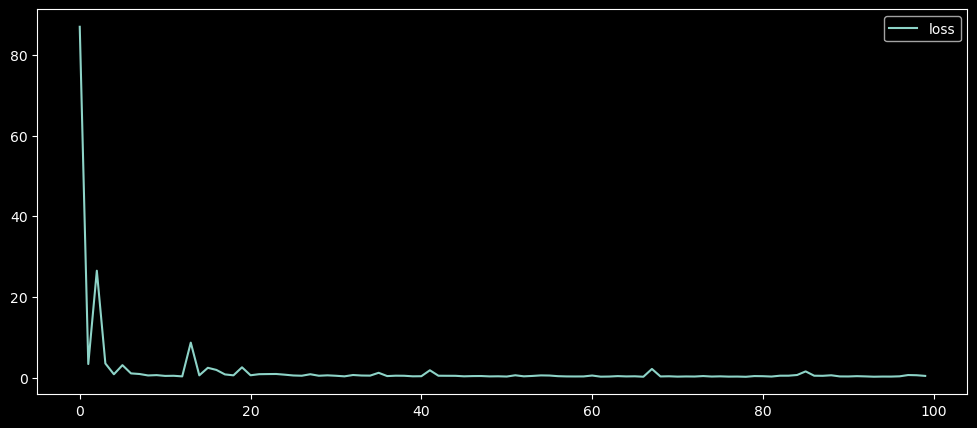

KeyboardInterrupt: 

In [42]:
from IPython.display import clear_output


epochs = 3
model = simple_model
opt = torch.optim.Adam(model.parameters())
criterion = nn.MSELoss()

history = []
for epoch in range(epochs):
    for batch, target in iterate_minibatches(data_train):
        # Preprocessing the batch data and target
        batch = torch.tensor(batch["FullDescription"], dtype=torch.long, device=device)
        target = torch.tensor(target, device=device)

        predictions = model(batch)
        predictions = predictions.flatten()

        # YOUR CODE HERE
        # Compute loss.
        loss = criterion(predictions, target)
        # YOUR CODE HERE
        # Train with backprop.
        loss.backward()
        opt.step()
        opt.zero_grad()
        history.append(loss.item())
        if len(history) % 10 == 0:
            clear_output(wait=True)
            plt.figure(figsize = (12, 5))
            plt.plot(history, label="loss")
            plt.legend()
            plt.show()

To evaluate the model we can switch it to `eval` state. Let's check the model quality.

In [48]:
with torch.no_grad():
    for batch, target in iterate_minibatches(data_val):
        batch = torch.tensor(batch["FullDescription"], dtype=torch.long, device=device)
        pred = model(batch)[:, 0].cpu().numpy()
        break
    

NameError: name 'model' is not defined

In [49]:
@torch.no_grad()
def evaluate_model(model, data, batch_size=256, name=None, **kwargs):
    squared_error = abs_error = num_samples = 0.0
    y_true = []
    y_pred = []
    
    data_iterator = iterate_minibatches(data, batch_size, shuffle=False, **kwargs)
    for batch, target in data_iterator:
        
        
        batch = torch.tensor(batch["FullDescription"], dtype=torch.long, device=device)
        pred = model(batch)[:, 0].cpu().numpy()
        
        y_true += list(target)
        y_pred += list(pred)
        
        squared_error += np.sum(np.square(pred - target))
        abs_error += np.sum(np.abs(pred - target))
        num_samples += len(target)

    if name is not None:
        print(f"{name}:")

    print(f"MSE: {squared_error / num_samples:.5f}")
    print(f"MAE: {abs_error / num_samples:.5f}")
    print(f"R2_score: {r2_score(y_true, y_pred):.5f}")
    
    return y_true, y_pred

y_true_train, y_pred_train = evaluate_model(simple_model, data_train, name="Train")
y_true_val, y_pred_val = evaluate_model(simple_model, data_val, name="Val")

KeyboardInterrupt: 

### Bonus area 1: three-headed network.

Now you can try to implement the network we've discussed above. Use [__PyTorch nn.Module API__](https://pytorch.org/docs/stable/nn.html#torch.nn.Module).

In [50]:
iterator = iterate_minibatches(data_train, 3)
batch, target = next(iterator)
list(batch.keys())

['Title', 'FullDescription', 'Categorical']

In [51]:
class ThreeInputsNet(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=64):
        super().__init__()

        self.title_emb = nn.Embedding(n_tokens, hid_size)
        # YOUR CODE HERE
        # Define modules to process the title.
        self.head_title = nn.Sequential(
            
            nn.Conv1d(hid_size, 2*hid_size, 3),
            nn.BatchNorm1d(2*hid_size),
            nn.ReLU(),
            nn.Conv1d(2*hid_size, 2*hid_size, 3),
            nn.BatchNorm1d(2*hid_size),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(1),
            nn.Flatten(),
            nn.Linear(2*hid_size, hid_size)
        )
        self.desc_emb = nn.Embedding(n_tokens, hid_size)
        # YOUR CODE HERE
        # Define modules to process the description.
        self.head_desc = nn.Sequential(
            
            nn.Conv1d(hid_size, hid_size, 5),
            nn.BatchNorm1d(hid_size),
            nn.ReLU(),
            nn.Conv1d(hid_size, 2*hid_size, 3),
            nn.BatchNorm1d(2*hid_size),
            nn.ReLU(),
            nn.Conv1d(2*hid_size, 2*hid_size, 3),
            nn.BatchNorm1d(2*hid_size),
            nn.ReLU(),
            nn.Conv1d(2*hid_size, 2*hid_size, 3),
            nn.BatchNorm1d(2*hid_size),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(1),
            nn.Flatten(),
            nn.Linear(2*hid_size, hid_size)
        )
        # YOUR CODE HERE
        # Define modules to process the categorical features.
        # self.category_out = ...
        self.head_categorical = nn.Linear(n_cat_features, hid_size)
        # YOUR CODE HERE
        # Define fully-connected part which will take outputs of
        # three heads and return the result.
        self.out = nn.Linear(3*hid_size, 1)

    
    def forward(self, whole_input):
        input1, input2, input3 = whole_input
        title_beg = self.title_emb(input1).permute((0, 2, 1))
        # YOUR CODE HERE
        # Process the title.
        title = self.head_title(title_beg)

        full_beg = self.desc_emb(input2).permute((0, 2, 1))
        # YOUR CODE HERE
        # Process the description.
        desc = self.head_desc(full_beg)

        # YOUR CODE HERE
        # Process the categorical features.
        category = self.head_categorical(input3)

        

        concatenated = torch.cat(
            [
                title.view(title.size(0), -1),
                desc.view(desc.size(0), -1),
                category.view(category.size(0), -1),
            ],
            dim=1,
        )

        # YOUR CODE HERE
        # Process the concatenated features to generate network output.
        out = self.out(concatenated)

        return out

In [52]:
train_iterator = iterate_minibatches(data_train, 256)
val_iterator = iterate_minibatches(data_val, 256)
batch, target = next(val_iterator)
batch["Title"].shape

(256, 14)

In [53]:
ex_inp1, ex_inp2, ex_inp3 = batch["Title"], batch["FullDescription"], batch["Categorical"]
ex_inp1, ex_inp2, ex_inp3 = torch.from_numpy(ex_inp1), torch.from_numpy(ex_inp2), torch.from_numpy(ex_inp3)

ex_inp1.shape, ex_inp2.shape, ex_inp3.shape 

(torch.Size([256, 14]), torch.Size([256, 913]), torch.Size([256, 3768]))

In [62]:
cnn_model = ThreeInputsNet(hid_size=128)
cnn_model_out = model((ex_inp1, ex_inp2, ex_inp3))

cnn_model_out.shape

torch.Size([256, 1])

In [63]:
print(f"Num of parameters in cnn model {sum([p.numel() for p in cnn_model.parameters()])}")

Num of parameters in cnn model 9729921


In [64]:
model = ThreeInputsNet(hid_size=128)
criterion = nn.MSELoss()
loss = criterion(model_out.flatten(), torch.from_numpy(target))
loss.backward()


In [65]:
def train_model(model, data_train, data_val, criterion, 
                optimizer, scheduler, batch_size, num_epochs):
    start_time = time.time()
    
    for epoch in range(num_epochs):
        train_iterator = iterate_minibatches(data_train, batch_size=batch_size, shuffle=True)
        val_iterator = iterate_minibatches(data_val, batch_size=batch_size, shuffle=False)
        start_epoch_time = time.time()
        print(15*"---")
        print(f"epoch: {epoch+1}/{num_epochs}")
        loss_train, loss_val = [], []
        y_true_train, y_true_val = [], []
        y_pred_train, y_pred_val = [], []
        for X_batch, y_batch in train_iterator:
            x_title, x_desc, x_cat = X_batch["Title"], X_batch["FullDescription"], X_batch["Categorical"]
            x_title, x_desc, x_cat = torch.from_numpy(x_title), torch.from_numpy(x_desc), torch.from_numpy(x_cat)
            x_title, x_desc, x_cat = x_title.to(device), x_desc.to(device), x_cat.to(device)
            y_batch = torch.from_numpy(y_batch).to(device)
            output = model((x_title, x_desc, x_cat))
            loss = criterion(output.flatten(), y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            loss_train.append(loss.item())
            y_true_train += list(y_batch.cpu().detach().numpy())
            y_pred_train += list(output.cpu().detach().numpy())
        # scheduler.step()
        
        with torch.no_grad():
            for X_batch, y_batch in val_iterator:
                x_title, x_desc, x_cat = X_batch["Title"], X_batch["FullDescription"], X_batch["Categorical"]
                x_title, x_desc, x_cat = torch.from_numpy(x_title), torch.from_numpy(x_desc), torch.from_numpy(x_cat)
                x_title, x_desc, x_cat = x_title.to(device), x_desc.to(device), x_cat.to(device)
                y_batch = torch.from_numpy(y_batch).to(device)
                output = model((x_title, x_desc, x_cat))
                loss = criterion(output.flatten(), y_batch)
                loss_val.append(loss.item())
                
                y_true_val += list(y_batch.cpu().detach().numpy())
                y_pred_val += list(output.cpu().detach().numpy())
        
        end_epoch_time = time.time()
        
        epoch_time = start_epoch_time - end_epoch_time
        print(f"Time for epoch: {(epoch_time//60):.1f} m, {(epoch_time%60):.2f} s")    
        print(f"Training loss: {np.mean(loss_train):.3f}, r2_score: {r2_score(y_true_train, y_pred_train):.3f} " )
        print(f"Validation loss: {np.mean(loss_val):.3f}, r2_score: {r2_score(y_true_val, y_pred_val):.3f} " )
        print()
    end_time = time.time()
    all_time = start_time - end_time
    print("****" * 15)
    print(f"Trainig time: {(all_time//60):.1f} m, {(all_time%60):1f} s")

In [66]:
model = ThreeInputsNet().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

In [67]:
train_model(model, data_train, data_val, criterion, optimizer,exp_lr_scheduler, batch_size = 256, num_epochs = 15)

---------------------------------------------
epoch: 1/15
Time for epoch: -2.0 m, 9.62 s
Training loss: 0.561, r2_score: -1.319 
Validation loss: 0.164, r2_score: 0.324 

---------------------------------------------
epoch: 2/15
Time for epoch: -2.0 m, 10.68 s
Training loss: 0.151, r2_score: 0.379 
Validation loss: 0.175, r2_score: 0.285 

---------------------------------------------
epoch: 3/15
Time for epoch: -2.0 m, 9.84 s
Training loss: 0.114, r2_score: 0.531 
Validation loss: 0.138, r2_score: 0.430 

---------------------------------------------
epoch: 4/15
Time for epoch: -2.0 m, 11.01 s
Training loss: 0.112, r2_score: 0.541 
Validation loss: 0.137, r2_score: 0.437 

---------------------------------------------
epoch: 5/15
Time for epoch: -2.0 m, 8.50 s
Training loss: 0.104, r2_score: 0.575 
Validation loss: 0.104, r2_score: 0.572 

---------------------------------------------
epoch: 6/15
Time for epoch: -2.0 m, 8.55 s
Training loss: 0.102, r2_score: 0.578 
Validation loss: 0.

In [68]:
@torch.no_grad()
def evaluate_model(model, data, batch_size=256, name=None, **kwargs):
    squared_error = abs_error = num_samples = 0.0
    y_true = []
    y_pred = []
    
    data_iterator = iterate_minibatches(data, batch_size, shuffle=False, **kwargs)
    for batch, target in data_iterator:
        
        x_title, x_desc, x_cat = batch["Title"], batch["FullDescription"], batch["Categorical"]
        x_title, x_desc, x_cat = torch.from_numpy(x_title), torch.from_numpy(x_desc), torch.from_numpy(x_cat)
        x_title, x_desc, x_cat = x_title.to(device), x_desc.to(device), x_cat.to(device)
        
        pred = model((x_title, x_desc, x_cat))[:, 0].cpu().numpy()
        
        y_true += list(target)
        y_pred += list(pred)
        
        squared_error += np.sum(np.square(pred - target))
        abs_error += np.sum(np.abs(pred - target))
        num_samples += len(target)

    if name is not None:
        print(f"{name}:")

    print(f"MSE: {squared_error / num_samples:.5f}")
    print(f"MAE: {abs_error / num_samples:.5f}")
    print(f"R2_score: {r2_score(y_true, y_pred):.5f}")
    
    return y_true, y_pred

y_true_train, y_pred_train = evaluate_model(model, data_train, name="Train")
y_true_val, y_pred_val = evaluate_model(model, data_val, name="Val")

Train:
MSE: 0.07877
MAE: 0.22711
R2_score: 0.67454
Val:
MSE: 0.10601
MAE: 0.25577
R2_score: 0.55899


In [69]:
import gc
torch.cuda.empty_cache()
gc.collect()

29308

### Bonus area 2: comparing RNN to CNN
Try implementing simple RNN (or LSTM) and applying it to this task. Compare the quality/performance of these networks. 
*Hint: try to build networks with ~same number of paremeters.*

In [75]:
n_cat_features=len(categorical_vectorizer.vocabulary_)

In [76]:
# YOUR CODE HERE

class rnn_model(nn.Module):
    
    def __init__(self, num_tokens=len(tokens), emb_dim=128, hid_dim=256):
        super().__init__()
        self.title_emb_layer = nn.Embedding(num_tokens, emb_dim)
        self.desc_emb_layer = nn.Embedding(num_tokens, emb_dim)
        
        self.title_rnn = nn.GRU(emb_dim, hid_dim, batch_first=True)
        self.desc_rnn =  nn.GRU(emb_dim, hid_dim, batch_first=True)
        self.cat_lin = nn.Linear(n_cat_features, hid_dim)
        self.out_layer = nn.Linear(3*hid_dim, 1)
        
    def forward(self, input_batch):
        inp_title, inp_desc, inp_cat = input_batch
        
        emb_title = self.title_emb_layer(inp_title) # batch_size, src_len, emb_dim
        emb_desc = self.desc_emb_layer(inp_desc) # batch_size, src_len, emb_dim
        _, title_out = self.title_rnn(emb_title) # batch_size, bi_direct*num_layers, hid_size
        _, desc_out = self.desc_rnn(emb_desc) # batch_size, bi_direct*num_layers, hid_size
        cat_out = self.cat_lin(inp_cat)  # batch_size, hid_size
        title_out = title_out.permute(1, 0, 2)
        desc_out = desc_out.permute(1, 0, 2)
        #print(title_out.shape, desc_out.shape, cat_out.shape)
        
        cat_features = torch.cat( [title_out.view(title_out.size(0), -1),
                                   desc_out.view(desc_out.size(0), -1),
                                   cat_out.view(cat_out.size(0), -1)
                                   ], dim=1)
        
        out = self.out_layer(cat_features)
        return out
    
        

In [77]:
train_iterator = iterate_minibatches(data_train, 256)
val_iterator = iterate_minibatches(data_val, 256)
batch, target = next(val_iterator)

In [78]:
ex_inp1, ex_inp2, ex_inp3 = batch["Title"], batch["FullDescription"], batch["Categorical"]
ex_inp1, ex_inp2, ex_inp3 = torch.from_numpy(ex_inp1), torch.from_numpy(ex_inp2), torch.from_numpy(ex_inp3)
ex_inp1, ex_inp2, ex_inp3 = ex_inp1[:2, :], ex_inp2[:2, :], ex_inp3[:2, :]
ex_inp1.shape, ex_inp2.shape, ex_inp3.shape 

(torch.Size([2, 19]), torch.Size([2, 1250]), torch.Size([2, 3768]))

In [79]:
rnn = rnn_model()
rnn((ex_inp1, ex_inp2, ex_inp3))

tensor([[-0.3199],
        [-0.3203]], grad_fn=<AddmmBackward0>)

In [81]:
print(f"Num of parameters in cnn model {sum([p.numel() for p in cnn_model.parameters()])}")
print(f"Num of parameters in rnn model {sum([p.numel() for p in rnn.parameters()])}")

Num of parameters in cnn model 9729921
Num of parameters in rnn model 9867265


In [116]:
rnn = rnn_model().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(rnn.parameters())
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)
train_model(rnn, data_train, data_val, criterion, optimizer,exp_lr_scheduler, batch_size = 256, num_epochs = 10)

---------------------------------------------
epoch: 1/10
Time for epoch: -4.0 m, 50.86 s
Training loss: 0.609, r2_score: -1.518 
Validation loss: 0.096, r2_score: 0.611 

---------------------------------------------
epoch: 2/10
Time for epoch: -4.0 m, 51.20 s
Training loss: 0.085, r2_score: 0.648 
Validation loss: 0.079, r2_score: 0.669 

---------------------------------------------
epoch: 3/10
Time for epoch: -4.0 m, 50.99 s
Training loss: 0.074, r2_score: 0.696 
Validation loss: 0.072, r2_score: 0.700 

---------------------------------------------
epoch: 4/10
Time for epoch: -4.0 m, 49.93 s
Training loss: 0.065, r2_score: 0.733 
Validation loss: 0.070, r2_score: 0.710 

---------------------------------------------
epoch: 5/10
Time for epoch: -4.0 m, 47.77 s
Training loss: 0.058, r2_score: 0.761 
Validation loss: 0.070, r2_score: 0.709 

---------------------------------------------
epoch: 6/10
Time for epoch: -4.0 m, 47.86 s
Training loss: 0.053, r2_score: 0.783 
Validation loss

In [123]:
torch.save(rnn.state_dict(), "rnn.pt")

In [124]:
y_true_train, y_pred_train = evaluate_model(rnn, data_train, name="Train")
y_true_val, y_pred_val = evaluate_model(rnn, data_val, name="Val")

Train:
MSE: 0.03063
MAE: 0.12735
R2_score: 0.87345
Val:
MSE: 0.05749
MAE: 0.17373
R2_score: 0.76086


### Bonus area 3: fixing the data leaks
Fix the data leak we ignored in the beginning of the __Deep Learning part__. Compare results with and without data leaks using same architectures and training time.


In [82]:
# YOUR CODE HERE
data_train, data_val = train_test_split(data, test_size=0.2, random_state=42)
data_train.index = range(len(data_train))
data_val.index = range(len(data_val))

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))


token_counts_ = Counter()

for row in data_train[text_columns].values.flatten():
    token_counts_.update(row.split())

Train size =  195814
Validation size =  48954


In [84]:
print("Total unique tokens :", len(token_counts_))
print("\n".join(map(str, token_counts_.most_common(n=5))))
print("...")
print("\n".join(map(str, token_counts_.most_common()[-3:])))

Total unique tokens : 179241
('and', 2123096)
('.', 2018563)
(',', 1853938)
('the', 1663289)
('to', 1613615)
...
('pate', 1)
('nurseportadown', 1)
('salesexecutivesx2northwestlondonesp', 1)


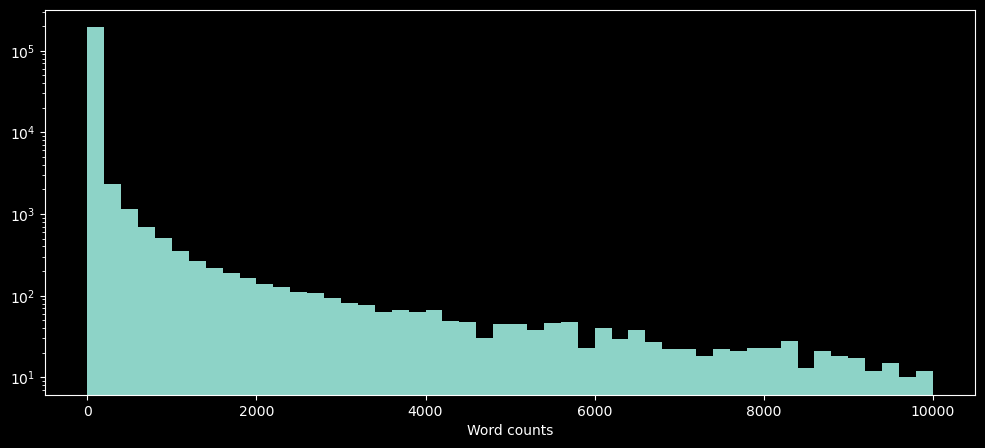

In [85]:
plt.figure(figsize=(12, 5))
plt.hist(list(token_counts.values()), range=[0, 10 ** 4], bins=50, log=True)
plt.xlabel("Word counts")
plt.show()

In [87]:
min_count = 10

# YOUR CODE HERE
# We shall only consider tokens that had at least min_count occurences.
# Create a list of such tokens.
tokens = [token for token, count in token_counts.items() if count > min_count]
print("Total unique tokens :", len(token_counts))
print("Considered unique tokens :", len(tokens))

Total unique tokens : 202704
Considered unique tokens : 32454


In [88]:
# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + sorted(tokens)
print("Vocabulary size:", len(tokens))

# YOUR CODE HERE
token_to_idx = {token: idx for idx, token in enumerate(tokens)}

UNK_IDX = token_to_idx[UNK]
PAD_IDX = token_to_idx[PAD]

def as_matrix(sequences, max_len=None):
    """Convert a list of tokens into a matrix with padding"""
    if isinstance(sequences[0], str):
        sequences = [seq.split(" ") for seq in sequences]

    sequences_max_len = max(len(seq) for seq in sequences)
    if max_len is None:
        max_len = sequences_max_len
    else:
        max_len = min(sequences_max_len, max_len)

    matrix = np.full((len(sequences), max_len), PAD_IDX)
    for i, seq in enumerate(sequences):
        for j, token in enumerate(seq):
            if j >= max_len:
                break

            matrix[i, j] = token_to_idx.get(token, UNK_IDX)

    return matrix

Vocabulary size: 32456


In [89]:
from sklearn.feature_extraction import DictVectorizer


# We only consider top-1k most frequent companies to minimize memory usage
company_counts = Counter(data_train["Company"])
top_companies = set(name for name, count in company_counts.most_common(1000))
data["Company"] = data_train["Company"].apply(
    lambda company: company if company in top_companies else "Other"
)

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data_train[categorical_columns].apply(dict, axis=1));

In [90]:
def make_batch(data, max_len=None, word_dropout=0):
    """
    Creates a neural-network-friendly dict from the batch data.
    :param word_dropout: replaces token index with UNK_IDX with this probability
    :returns: a dict with {'title' : int64[batch, title_max_len], 
                           "FullDescription": int64[batch, title_max_len],
                           "Categorical"
    """
    batch = {}
    batch["Title"] = as_matrix(data["Title"].values, max_len)
    batch["FullDescription"] = as_matrix(data["FullDescription"].values, max_len)
    batch["Categorical"] = categorical_vectorizer.transform(
        data[categorical_columns].apply(dict, axis=1)
    )

    if word_dropout != 0:
        batch["FullDescription"] = apply_word_dropout(batch["FullDescription"], 1.0 - word_dropout)

    if target_column in data.columns:
        batch[target_column] = data[target_column].values

    return batch


def apply_word_dropout(matrix, keep_prob, replace_with=UNK_IDX):
    dropout_mask = np.random.choice(2, np.shape(matrix), p=[keep_prob, 1 - keep_prob])
    dropout_mask &= matrix != PAD_IDX
    return np.choose(dropout_mask, [matrix, np.full_like(matrix, replace_with)])


def iterate_minibatches(data, batch_size=256, shuffle=True, cycle=False, **kwargs):
    """iterates minibatches of data in random order"""
    while True:
        indices = np.arange(len(data))
        if shuffle:
            indices = np.random.permutation(indices)

        for start in range(0, len(indices), batch_size):
            batch = make_batch(data.iloc[indices[start : start + batch_size]], **kwargs)
            target = batch.pop(target_column)
            yield batch, target

        if not cycle:
            break

In [95]:
n_cat_features=len(categorical_vectorizer.vocabulary_)
n_cat_features

3579

In [96]:
model = ThreeInputsNet(n_tokens=len(tokens), n_cat_features=n_cat_features).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)


train_model(model, data_train, data_val, criterion, optimizer, exp_lr_scheduler, 
            batch_size = 256, num_epochs = 15)

---------------------------------------------
epoch: 1/15
Time for epoch: -2.0 m, 7.75 s
Training loss: 0.536, r2_score: -1.217 
Validation loss: 0.196, r2_score: 0.187 

---------------------------------------------
epoch: 2/15
Time for epoch: -2.0 m, 7.64 s
Training loss: 0.154, r2_score: 0.364 
Validation loss: 0.120, r2_score: 0.500 

---------------------------------------------
epoch: 3/15
Time for epoch: -2.0 m, 8.05 s
Training loss: 0.115, r2_score: 0.526 
Validation loss: 0.132, r2_score: 0.453 

---------------------------------------------
epoch: 4/15
Time for epoch: -2.0 m, 5.71 s
Training loss: 0.091, r2_score: 0.626 
Validation loss: 0.140, r2_score: 0.417 

---------------------------------------------
epoch: 5/15
Time for epoch: -2.0 m, 6.81 s
Training loss: 0.084, r2_score: 0.651 
Validation loss: 0.077, r2_score: 0.679 

---------------------------------------------
epoch: 6/15
Time for epoch: -2.0 m, 7.98 s
Training loss: 0.086, r2_score: 0.646 
Validation loss: 0.09

In [97]:
y_true_train, y_pred_train = evaluate_model(model, data_train, name="Train")
y_true_val, y_pred_val = evaluate_model(model, data_val, name="Val")

Train:
MSE: 0.03913
MAE: 0.14709
R2_score: 0.83826
Val:
MSE: 0.07014
MAE: 0.19610
R2_score: 0.70832


In [98]:
import gc
torch.cuda.empty_cache()
gc.collect()

15983

In [99]:
rnn = rnn_model().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(rnn.parameters())
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)
train_model(rnn, data_train, data_val, criterion, optimizer,exp_lr_scheduler, batch_size = 256, num_epochs = 10)

---------------------------------------------
epoch: 1/10
Time for epoch: -4.0 m, 48.91 s
Training loss: 0.656, r2_score: -1.710 
Validation loss: 0.094, r2_score: 0.610 

---------------------------------------------
epoch: 2/10
Time for epoch: -4.0 m, 49.51 s
Training loss: 0.085, r2_score: 0.647 
Validation loss: 0.078, r2_score: 0.677 

---------------------------------------------
epoch: 3/10
Time for epoch: -4.0 m, 49.61 s
Training loss: 0.073, r2_score: 0.699 
Validation loss: 0.070, r2_score: 0.710 

---------------------------------------------
epoch: 4/10
Time for epoch: -4.0 m, 49.10 s
Training loss: 0.063, r2_score: 0.738 
Validation loss: 0.066, r2_score: 0.726 

---------------------------------------------
epoch: 5/10
Time for epoch: -4.0 m, 50.07 s
Training loss: 0.056, r2_score: 0.769 
Validation loss: 0.064, r2_score: 0.735 

---------------------------------------------
epoch: 6/10
Time for epoch: -4.0 m, 49.57 s
Training loss: 0.050, r2_score: 0.793 
Validation loss

In [100]:
y_true_train, y_pred_train = evaluate_model(rnn, data_train, name="Train")
y_true_val, y_pred_val = evaluate_model(rnn, data_val, name="Val")

Train:
MSE: 0.02646
MAE: 0.11733
R2_score: 0.89064
Val:
MSE: 0.05551
MAE: 0.16891
R2_score: 0.76916


__Terrible start-up idea #1962:__ make a tool that automaticaly rephrases your job description (or CV) to meet salary expectations :)